In [1]:
#import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy.stats.mstats import mode
from fancyimpute import KNN 
from sklearn.ensemble import RandomForestRegressor
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from ggplot import *

C:\Users\parul\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\parul\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


In [2]:
#set working directory
os.chdir("C:/Users/parul/Desktop/Data Science/PROJECT/project2")

In [3]:
os.getcwd()

'C:\\Users\\parul\\Desktop\\Data Science\\PROJECT\\project2'

In [4]:
#Load dataset
dataset=pd.read_excel("Absenteeism_at_work_Project.xls")

<h3>Data Exploration</h3>

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
ID                                 740 non-null int64
Reason.for.absence                 737 non-null float64
Month.of.absence                   739 non-null float64
Day.of.the.week                    740 non-null int64
Seasons                            740 non-null int64
Transportation.expense             733 non-null float64
Distance.from.Residence.to.Work    737 non-null float64
Service.time                       737 non-null float64
Age                                737 non-null float64
Work.load.Average.per.day          730 non-null float64
Hit.target                         734 non-null float64
Disciplinary.failure               734 non-null float64
Education                          730 non-null float64
Son                                734 non-null float64
Social.drinker                     737 non-null float64
Social.smoker                      736 non-null float64
Pet  

In [6]:
type(dataset)

pandas.core.frame.DataFrame

<h2>DATA PRE-PROCESSING</h2>

<h3>Feature Engineering</h3>

In [7]:
#create a new column year for time series analysis
dataset.loc[0:112, 'year'] = 2007
dataset.loc[113:358, 'year'] = 2008
dataset.loc[359:570, 'year'] = 2009
dataset.loc[571:740, 'year'] = 2010

In [8]:
dataset.shape

(740, 22)

In [9]:
dataset.head()

,ID,Reason.for.absence,Month.of.absence,Day.of.the.week,Seasons,Transportation.expense,Distance.from.Residence.to.Work,Service.time,Age,Work.load.Average.per.day,...,Education,Son,Social.drinker,Social.smoker,Pet,Weight,Height,Body.mass.index,Absenteeism.time.in.hours,year
0,11,26.0,7.0,3,1,289.0,36.0,13.0,33.0,239554.0,...,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,4.0,2007.0
1,36,0.0,7.0,3,1,118.0,13.0,18.0,50.0,239554.0,...,1.0,1.0,1.0,0.0,0.0,98.0,178.0,31.0,0.0,2007.0
2,3,23.0,7.0,4,1,179.0,51.0,18.0,38.0,239554.0,...,1.0,0.0,1.0,0.0,0.0,89.0,170.0,31.0,2.0,2007.0
3,7,7.0,7.0,5,1,279.0,5.0,14.0,39.0,239554.0,...,1.0,2.0,1.0,1.0,0.0,68.0,168.0,24.0,4.0,2007.0
4,11,23.0,7.0,5,1,289.0,36.0,13.0,33.0,239554.0,...,1.0,2.0,1.0,0.0,1.0,90.0,172.0,30.0,2.0,2007.0


In [10]:
#rename columns (. creates issue while using functions so replace . with _)
dataset.columns = dataset.columns.str.replace('.', '_')
column=dataset.columns.tolist()

In [11]:
type(column)

list

In [12]:
#reorder the position of response variable
temp=column[20]
column[20]=column[21]
column[21]=temp
dataset=dataset.reindex(columns=column)

<h3>Missing value imputation</h3>

In [13]:
missing_val = pd.DataFrame(dataset.isnull().sum())
#Reset index
missing_val = missing_val.reset_index()
#Rename variable
missing_val = missing_val.rename(columns = {'index': 'Variables', 0: 'Missing_value_num'})
#descending order
missing_val = missing_val.sort_values('Missing_value_num', ascending = False).reset_index(drop = True)
missing_val

,Variables,Missing_value_num
0,Body_mass_index,31
1,Absenteeism_time_in_hours,22
2,Height,14
3,Work_load_Average_per_day,10
4,Education,10
5,Transportation_expense,7
6,Son,6
7,Hit_target,6
8,Disciplinary_failure,6
9,Social_smoker,4


In [14]:
#remove last 3 observations of dataset as they dont signify anything (have 0 values)
dataset=dataset.loc[1:736,:]
#correcting a missing value
dataset.loc[66,'Month_of_absence']=10

In [15]:
cat_var=['ID','Reason_for_absence','Month_of_absence','Day_of_the_week','Seasons','Disciplinary_failure','Education','Social_drinker','Social_smoker','Son','Pet']
#convert to object datatype
for i in cat_var:
    print(i)
    dataset[i]=dataset[i].astype('object')

ID
Reason_for_absence
Month_of_absence
Day_of_the_week
Seasons
Disciplinary_failure
Education
Social_drinker
Social_smoker
Son
Pet


In [16]:
#numeric variable
#num_var=['Body_mass_index','Absenteeism_time_in_hours','Height','Work_load_Average_per_day','Transportation_expense','Hit_target','Distance_from_Residence_to_Work','Service_time','Age','Weight']
num_columns=dataset.select_dtypes(exclude=['object'])
num_var=num_columns.columns
num_var

Index(['Transportation_expense', 'Distance_from_Residence_to_Work',
       'Service_time', 'Age', 'Work_load_Average_per_day ', 'Hit_target',
       'Weight', 'Height', 'Body_mass_index', 'year',
       'Absenteeism_time_in_hours'],
      dtype='object')

In [17]:
#impute missing value for categorical variables using mode over data of each year
for i in cat_var:
    dataset[i]=dataset.groupby('year')[i].transform(lambda x: x.fillna(x.mode()[0]))
#impute missing value for numeric variables using mean over data of each year    
for i in num_var:
    dataset[i]=dataset.groupby('year')[i].transform(lambda x: x.fillna(x.mean()))

In [18]:
#check missing values
dataset.isnull().sum()

ID                                 0
Reason_for_absence                 0
Month_of_absence                   0
Day_of_the_week                    0
Seasons                            0
Transportation_expense             0
Distance_from_Residence_to_Work    0
Service_time                       0
Age                                0
Work_load_Average_per_day          0
Hit_target                         0
Disciplinary_failure               0
Education                          0
Son                                0
Social_drinker                     0
Social_smoker                      0
Pet                                0
Weight                             0
Height                             0
Body_mass_index                    0
year                               0
Absenteeism_time_in_hours          0
dtype: int64

In [19]:
#convert categorical variable back to object data type
for i in cat_var:
    dataset[i]=dataset[i].astype('int')
    dataset[i]=dataset[i].astype('object')

<h3>Outlier Analysis</h3>

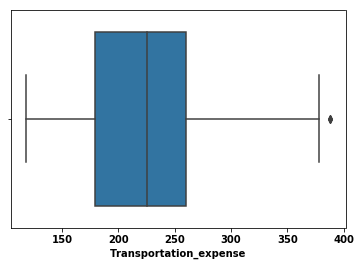

In [20]:
#f, axes = plt.subplots(4, 3, figsize=(20, 20), sharex=True)
sns.boxplot(dataset['Transportation_expense'])

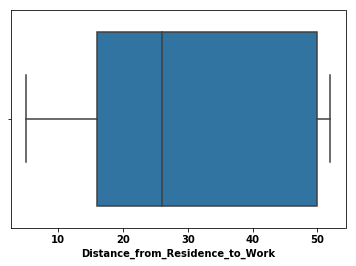

In [21]:
sns.boxplot(dataset['Distance_from_Residence_to_Work'])

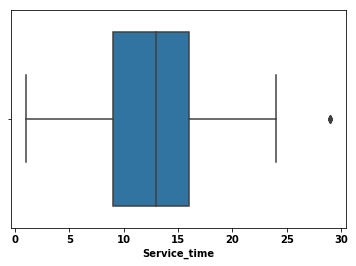

In [22]:
sns.boxplot(dataset['Service_time'])

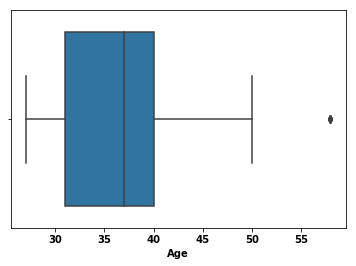

In [23]:
sns.boxplot(dataset['Age'])

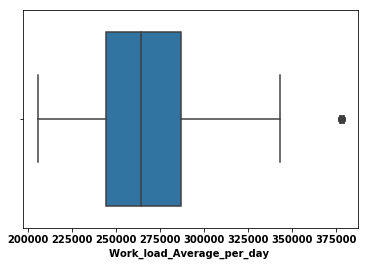

In [24]:
sns.boxplot(dataset['Work_load_Average_per_day '])

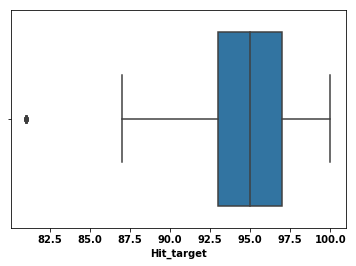

In [25]:
sns.boxplot(dataset['Hit_target'])

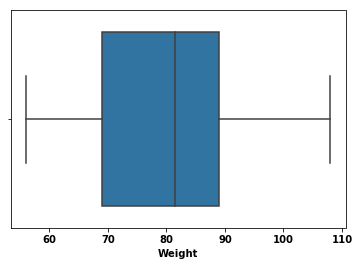

In [26]:
sns.boxplot(dataset['Weight'])

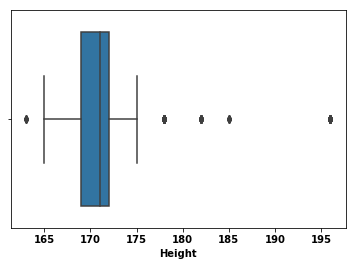

In [27]:
sns.boxplot(dataset['Height'])

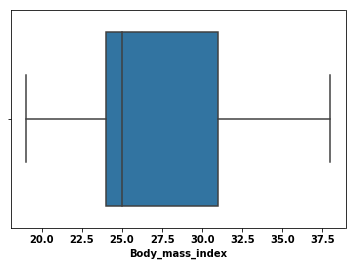

In [28]:
sns.boxplot(dataset['Body_mass_index'])

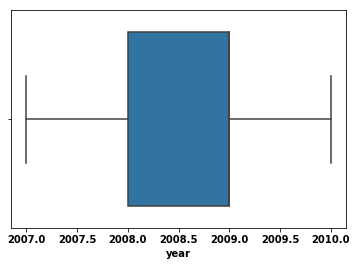

In [29]:
sns.boxplot(dataset['year'])

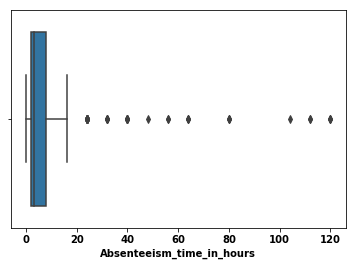

In [30]:
sns.boxplot(dataset['Absenteeism_time_in_hours'])

In [31]:
# #Detect and delete outliers from data
for i in num_var:
    print(i)
    q75, q25 = np.percentile(dataset.loc[:,i], [75 ,25])
    iqr = q75 - q25
    min = q25 - (iqr*1.5)
    max = q75 + (iqr*1.5)
    print(min)
    print(max)
    dataset.loc[dataset[i] < min,i] = np.nan
    dataset.loc[dataset[i] > max,i] = np.nan

Transportation_expense
57.5
381.5
Distance_from_Residence_to_Work
-35.0
101.0
Service_time
-1.5
26.5
Age
17.5
53.5
Work_load_Average_per_day 
180176.5
351404.5
Hit_target
87.0
103.0
Weight
39.0
119.0
Height
164.5
176.5
Body_mass_index
13.5
41.5
year
2006.5
2010.5
Absenteeism_time_in_hours
-7.0
17.0


In [32]:
#number of outliers
dataset.isnull().sum()

ID                                   0
Reason_for_absence                   0
Month_of_absence                     0
Day_of_the_week                      0
Seasons                              0
Transportation_expense               3
Distance_from_Residence_to_Work      0
Service_time                         5
Age                                  8
Work_load_Average_per_day           31
Hit_target                          19
Disciplinary_failure                 0
Education                            0
Son                                  0
Social_drinker                       0
Social_smoker                        0
Pet                                  0
Weight                               0
Height                             119
Body_mass_index                      0
year                                 0
Absenteeism_time_in_hours           43
dtype: int64

In [33]:
#Impute outliers using KNN
dataset = pd.DataFrame(KNN(k = 3).complete(dataset), columns = dataset.columns)

Imputing row 1/736 with 1 missing, elapsed time: 0.984
Imputing row 101/736 with 0 missing, elapsed time: 1.020
Imputing row 201/736 with 0 missing, elapsed time: 1.021
Imputing row 301/736 with 0 missing, elapsed time: 1.024
Imputing row 401/736 with 0 missing, elapsed time: 1.025
Imputing row 501/736 with 0 missing, elapsed time: 1.026
Imputing row 601/736 with 0 missing, elapsed time: 1.027
Imputing row 701/736 with 0 missing, elapsed time: 1.028


In [34]:
#convert categorical variable back to object data type
for i in cat_var:
    dataset[i]=dataset[i].astype('int')
    dataset[i]=dataset[i].astype('object')
for i in num_var:
    dataset[i]=np.round(dataset[i])

<h3>Feature Selection</h3>

In [35]:
def heatMap(df):
    #Create Correlation df
    corr_matrix = df.corr()
    #Plot figsize
    fig,ax =plt.subplots(figsize=(12, 10))
    #Generate Color Map, red & blue
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr_matrix, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns);
    #Apply yticks
    plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
    #show plot
    plt.show()
    return corr_matrix

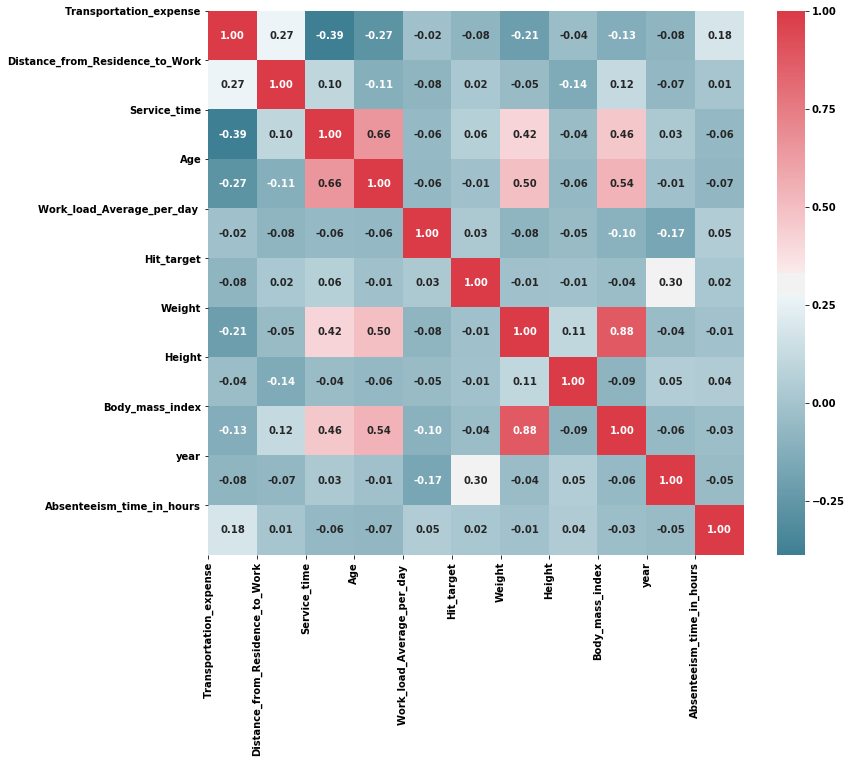

In [36]:
corr_matrix=heatMap(dataset[num_var])

<h3>Feature Ranking using Random Forest</h3>

Features sorted by their score:


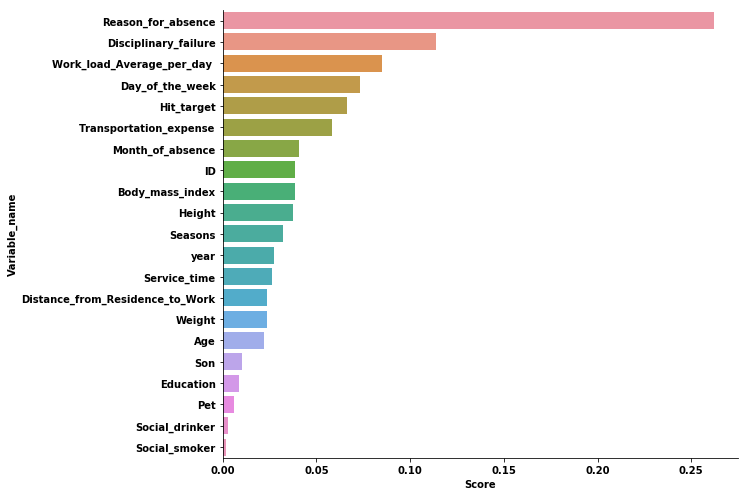

In [37]:
#Feature ranking using Mean decrease impurity
rf = RandomForestRegressor()
predictor=dataset.drop(['Absenteeism_time_in_hours'],axis=1)
rf.fit(predictor, dataset['Absenteeism_time_in_hours'])
print( "Features sorted by their score:")
aa=sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), dataset.columns), 
             reverse=True)
aa=pd.DataFrame(aa)
aa=aa.rename(columns={0:'Score',1:'Variable_name'})
#descending order
aa=aa.sort_values('Score', ascending = False).reset_index(drop = True)
aa=aa[['Variable_name','Score']]
sns.factorplot(y='Variable_name',x='Score',data=aa,kind='bar',aspect=1.5, size=7)

In [38]:
aa

,Variable_name,Score
0,Reason_for_absence,0.2619
1,Disciplinary_failure,0.1136
2,Work_load_Average_per_day,0.0853
3,Day_of_the_week,0.0734
4,Hit_target,0.0666
5,Transportation_expense,0.0585
6,Month_of_absence,0.0409
7,ID,0.0386
8,Body_mass_index,0.0385
9,Height,0.0377


In [39]:
aa.head()

,Variable_name,Score
0,Reason_for_absence,0.2619
1,Disciplinary_failure,0.1136
2,Work_load_Average_per_day,0.0853
3,Day_of_the_week,0.0734
4,Hit_target,0.0666


<h3>Univariate Analysis</h3>

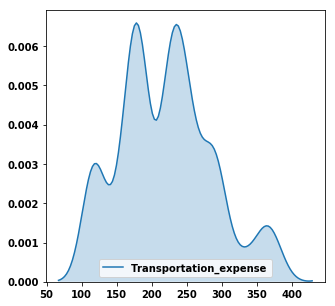

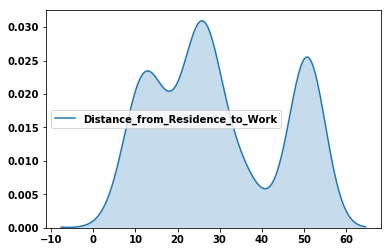

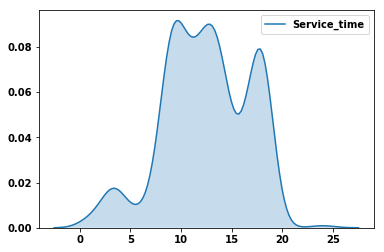

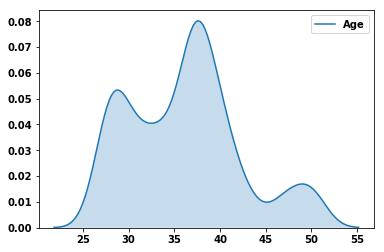

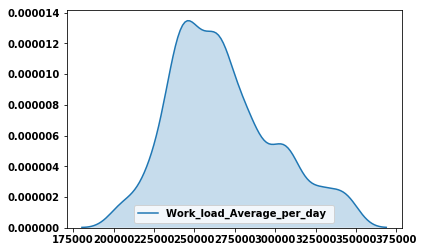

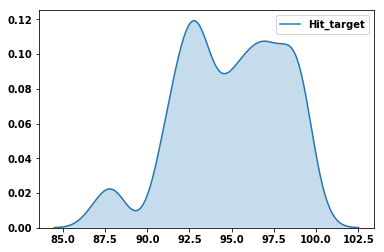

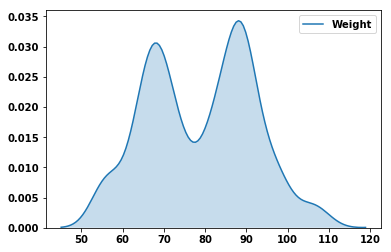

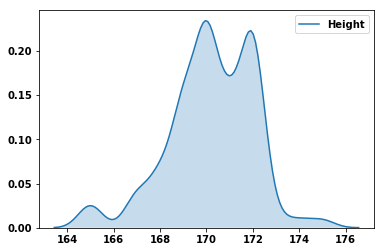

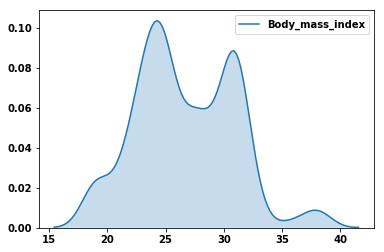

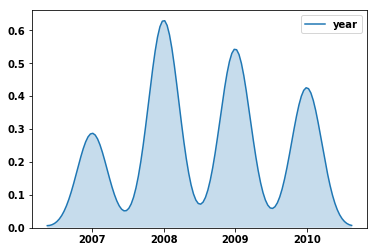

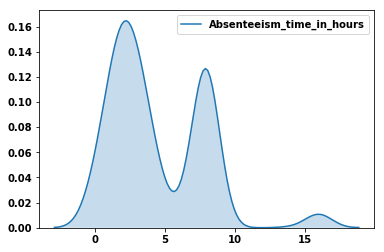

In [40]:
#Density plots of numeric variables
plt.figure(figsize=(5,5))
for i in num_var:
    sns.kdeplot(dataset[i],shade=True)
    plt.show()

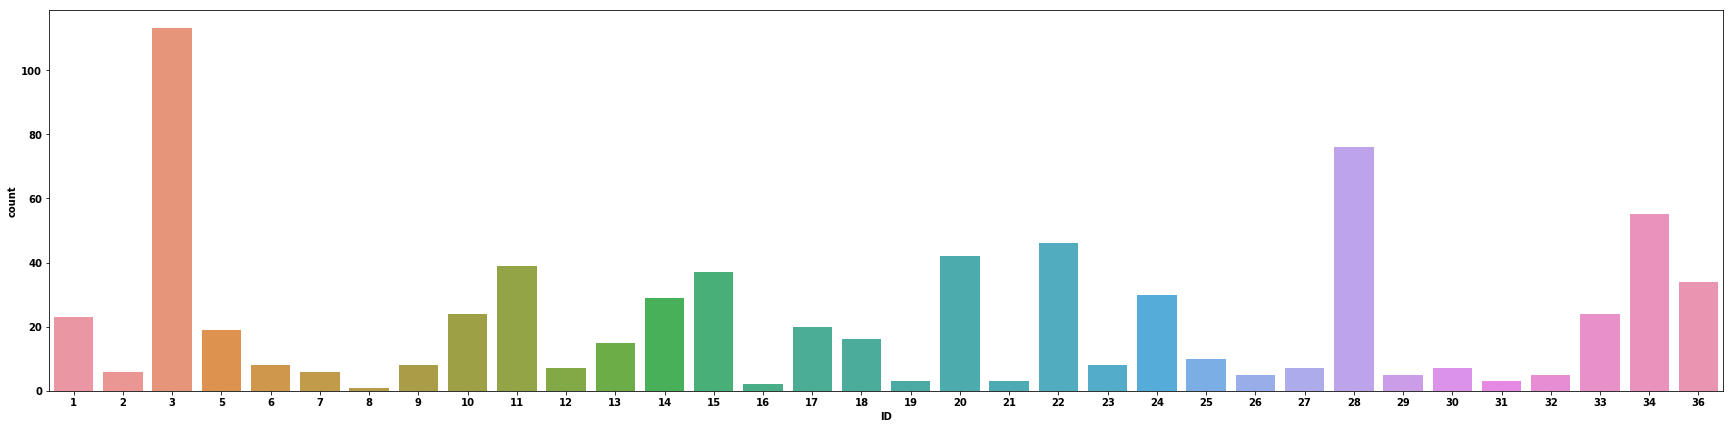

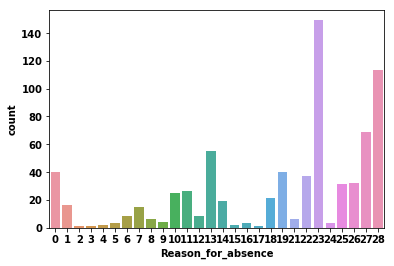

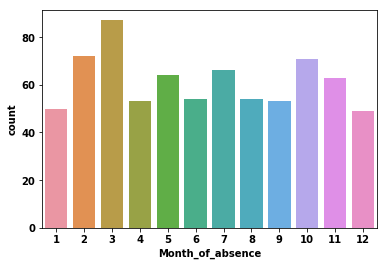

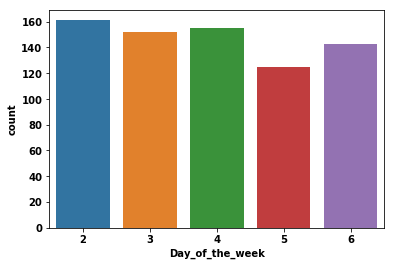

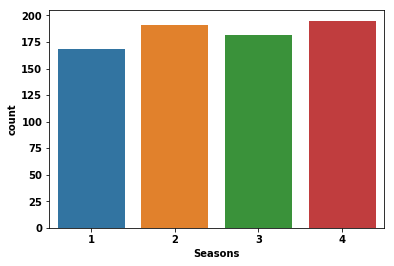

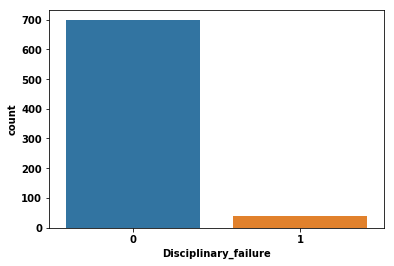

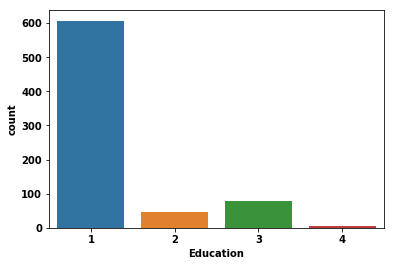

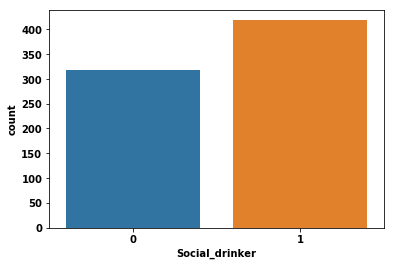

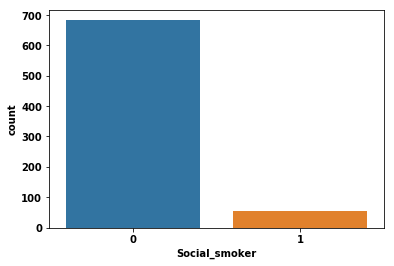

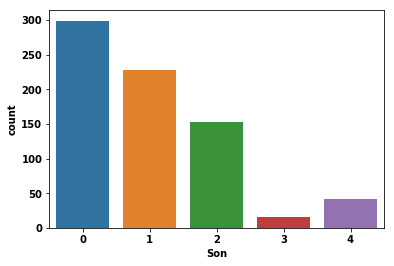

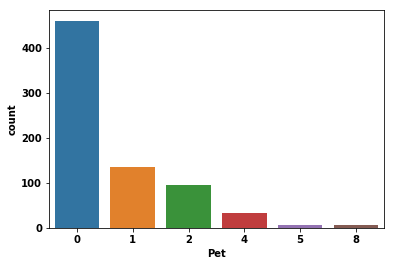

In [41]:
#count plots of categorical variables
plt.figure(figsize=(30,7))
for i in cat_var:
    sns.countplot(x=i,data=dataset)
    plt.savefig("Uni{i}.png".format(i=i))
    plt.show()

<h3>Bivariate Analysis</h3>

In [42]:
dataset['Absenteeism_time_in_hours'].sum()

3280.0

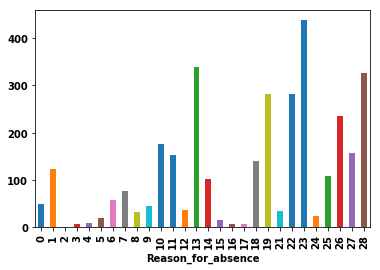

In [43]:
hours_vs_reason=dataset.groupby('Reason_for_absence')['Absenteeism_time_in_hours'].sum()
#print(hours_vs_reason)
hours_vs_reason.plot('bar')
plt.savefig("hours_vs_reason.png")
#OR
#x = hours_vs_reason.index
#y = hours_vs_reason.values
#plt.bar(x, y)

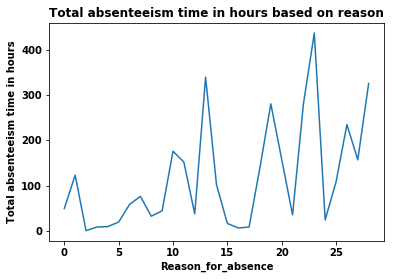

In [44]:
var = dataset.groupby('Reason_for_absence')['Absenteeism_time_in_hours'].sum()
f, ax1 = plt.subplots(1, 1)
ax1.set_xlabel('Reason for absence')  #X-axis label
ax1.set_ylabel('Total absenteeism time in hours') #Y-axis label
ax1.set_title("Total absenteeism time in hours based on reason") #Chart title
var.plot(kind='line')
plt.savefig('GP_ROA.png')

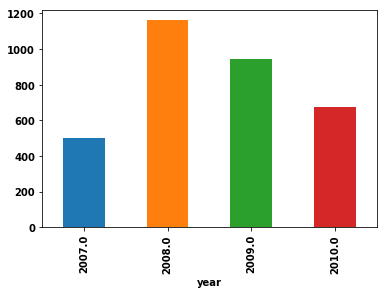

In [45]:
hours_vs_year=dataset.groupby('year')['Absenteeism_time_in_hours'].sum()
plt.savefig("hours_vs_year.png")
hours_vs_year.plot('bar')

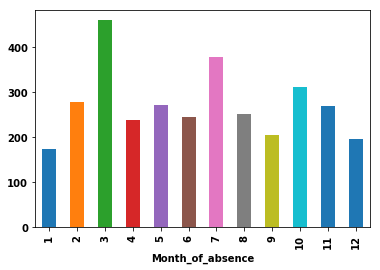

In [46]:
hours_vs_month=dataset.groupby('Month_of_absence')['Absenteeism_time_in_hours'].sum()
plt.savefig("hours_vs_month.png")
hours_vs_month.plot('bar')

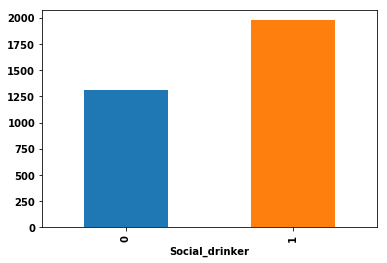

In [47]:
hours_vs_drinker=dataset.groupby('Social_drinker')['Absenteeism_time_in_hours'].sum()
plt.savefig("hours_vs_drinker.png")
hours_vs_drinker.plot('bar')

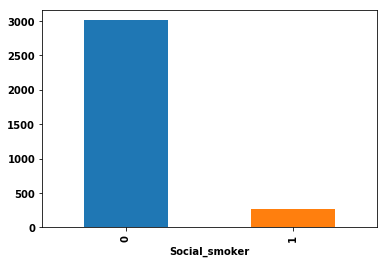

In [48]:
hours_vs_smoker=dataset.groupby('Social_smoker')['Absenteeism_time_in_hours'].sum()
plt.savefig("hours_vs_smoker.png")
hours_vs_smoker.plot('bar')

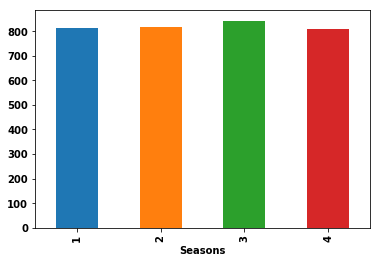

In [49]:
hours_vs_seasons=dataset.groupby('Seasons')['Absenteeism_time_in_hours'].sum()
plt.savefig("hours_vs_seasons.png")
hours_vs_seasons.plot('bar')

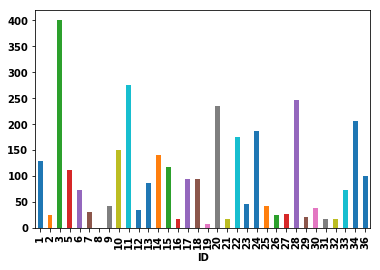

In [50]:
hours_vs_ID=dataset.groupby('ID')['Absenteeism_time_in_hours'].sum()
plt.savefig("hours_vs_ID.png")
hours_vs_ID.plot('bar')

<h2>Time series Modelling</h2>

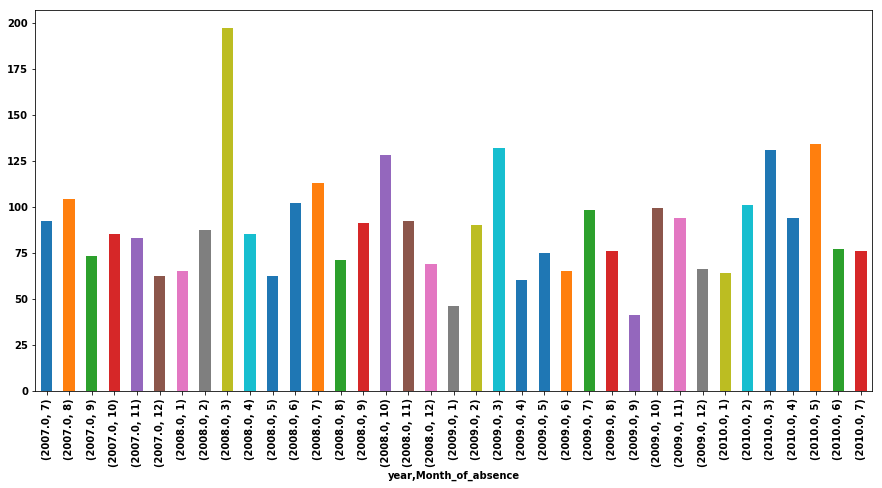

In [53]:
#creating a time series
#aggregate absenteeism hours using month and year
plt.figure(figsize=(15,7))
hours_vs_month_year=dataset.groupby(['year','Month_of_absence'])['Absenteeism_time_in_hours'].sum()
hours_vs_month_year.plot('bar')

In [54]:
dataset_ts=hours_vs_month_year
dataset_ts.index=pd.date_range(start = '2007-07-01',end='2010-08-01', freq = 'M')

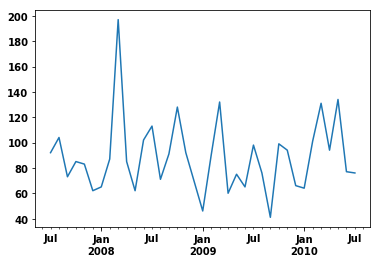

In [55]:
dataset_ts.plot()

In [56]:
#Check whether data is stationary or not 
#a) Augmented dickey Fuller test
X = hours_vs_month_year.values
result = adfuller(dataset_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
#p-value shows time series is stationary

ADF Statistic: -5.665478
p-value: 0.000001
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613


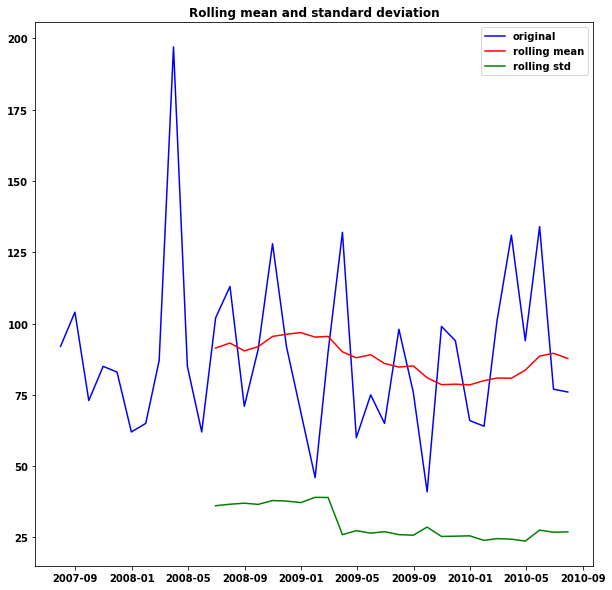

In [57]:
#check Time series stationarity
#b)plot rolling statistics
plt.figure(figsize=(10,10))
orig=plt.plot(dataset_ts,color='blue',label='original')
rollmean=dataset_ts.rolling(window=12).mean()
mean=plt.plot(rollmean,color='red',label='rolling mean')
rollstd=dataset_ts.rolling(window=12).std()
std=plt.plot(rollstd,color='green',label='rolling std')
plt.legend(loc='best')
plt.title('Rolling mean and standard deviation')
plt.show(block=False)

In [58]:
#Decompose time series into its constituents
decomposition=seasonal_decompose(dataset_ts)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

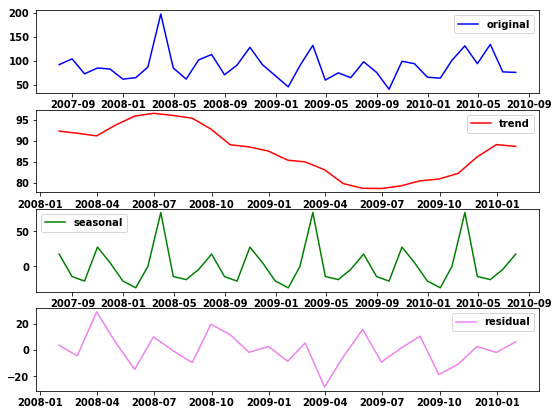

In [59]:
plt.figure(figsize=(9,7))
plt.subplot(411)
plt.plot(dataset_ts,color='blue',label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,color='red',label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,color='green',label='seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,color='violet',label='residual')
plt.legend(loc='best')

In [60]:
#Divide data into train and test data
train_ts=dataset_ts[0:30]
test_ts=dataset_ts[30:]
#The training data is fed to the model. The model is further used for forecasting test data value and values for the year 2011.
#The accuracy of the model is checked by comparing the test data's observed and forecasted values

<h3>Method 1: Holt Winters Exponential Smoothning for time series forecasting</h3>

In [61]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals


def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

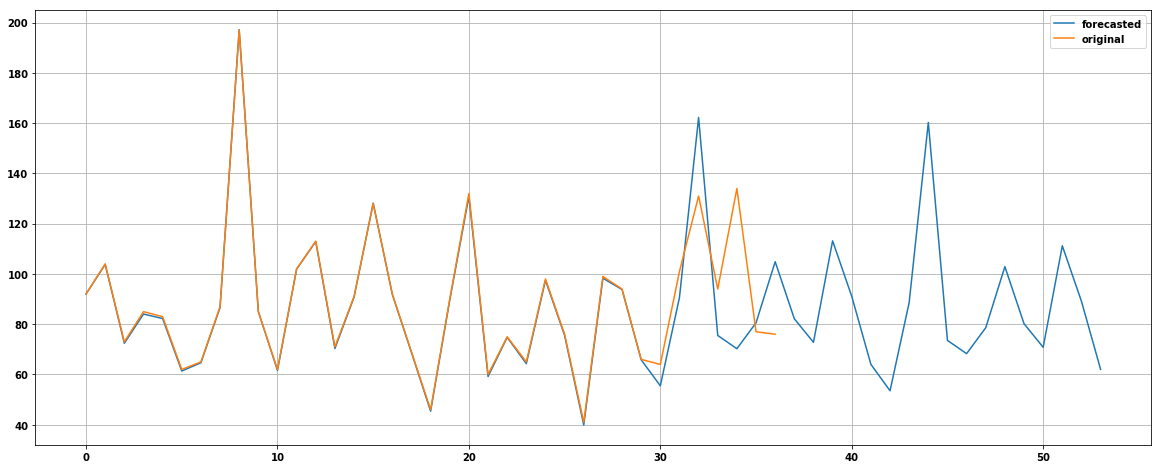

In [62]:
#forecasting values for test data and 2011
result=triple_exponential_smoothing(train_ts, 12, 0.716, 0.029, 0.993, 24)
plt.figure(figsize=(20, 8))
plt.plot(result,label='forecasted')
plt.plot(dataset_ts.values,label='original')
plt.legend()
plt.axis('tight')
plt.grid(True)

In [63]:
#Validation
#a) MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#b) RMSE (Root Mean Square Error)
mse = mean_squared_error(result[30:37], test_ts.values)
rmse = np.sqrt(mse)

mape=mean_absolute_percentage_error(test_ts.values, result[30:37])
print('MAPE: %.2f%%' % mape)
print('RMSE: %.2f%%' % rmse)

MAPE: 22.47%
RMSE: 30.26%


In [71]:
#Total absenteeism expected in the year 2011
sum(result[37:])

1462.453396622436

<h3>Method 2: Seasonal ARIMA</h3>

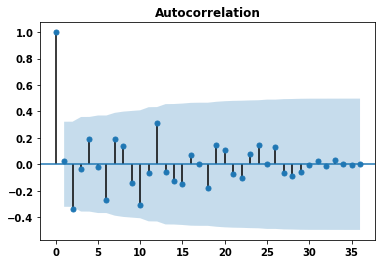

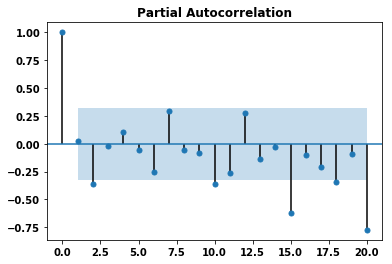

In [72]:
#plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
#plot ACF
plot_acf(dataset_ts)
pyplot.show()
#plot PACF
plot_pacf(dataset_ts,lags=20)
pyplot.show()

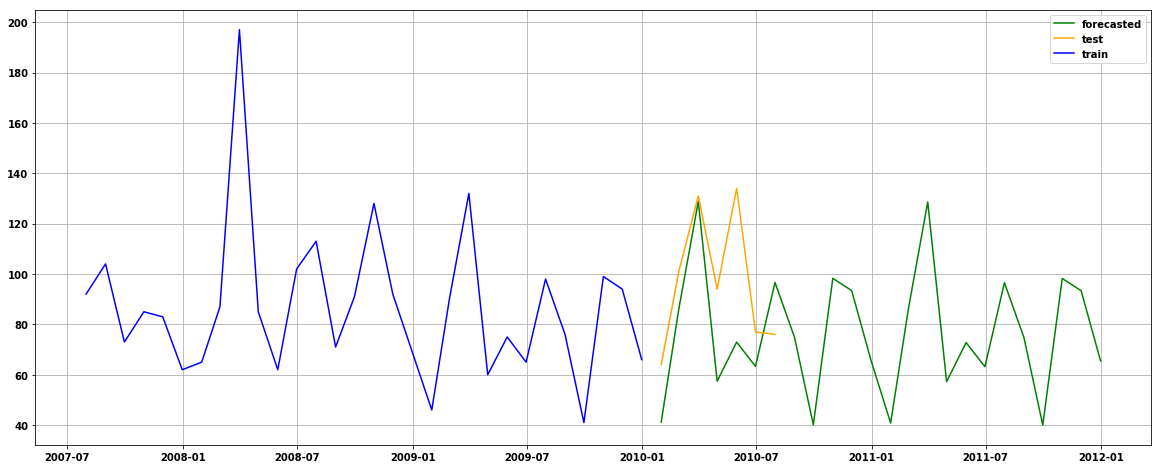

In [107]:
#Looking at the ACF and PACF plots of the series we see our first significant value at lag 2 for ACF and 
#at the same lag 2 for the PACF which suggest to use p = 2 and q = 2. d=0 as our series is not differenced.
#We also have a big value at lag 12 in the ACF plot which suggests our season is S = 12 and since this lag is
#positive it suggests P = 1 and Q = 0. Since this is not a differenced series for SARIMA we set d = 0, 
#and since the seasonal pattern is not stable over time we set D = 0.

#d=number of times series is difference to make it stationary
#our time series is stationary so d=0
# fit model on training data
model = SARIMAX(train_ts, order=(1, 0, 1), seasonal_order=(0, 1, 0, 12))
model_fit = model.fit(disp=False)
#forecast values of test data and future 2011 values
forecast=model_fit.forecast(24)
#Plot original and forecasted points
plt.figure(figsize=(20, 8))
plt.plot(forecast,color='green',label='forecasted')
plt.plot(test_ts,color='orange',label='test')
plt.plot(train_ts,color='blue',label='train')
plt.legend()
plt.axis('tight')
plt.grid(True)

In [108]:
#Validation
#a) MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#b) RMSE (Root Mean Square Error)
mse = mean_squared_error(forecast[0:7], test_ts.values)
rmse = np.sqrt(mse)

mape=mean_absolute_percentage_error(test_ts.values, forecast[0:7])
print('MAPE: %.2f%%' % mape)
print('RMSE: %.2f%%' % rmse)

MAPE: 25.91%
RMSE: 30.29%


In [109]:
#total absenteeism expected in the year 2011
sum(forecast[7:])

1289.1521808424145

In [88]:
forecast[7:]

2010-08-31     76.0
2010-09-30     41.0
2010-10-31     99.0
2010-11-30     94.0
2010-12-31     66.0
2011-01-31     46.0
2011-02-28     90.0
2011-03-31    132.0
2011-04-30     60.0
2011-05-31     75.0
2011-06-30     65.0
2011-07-31     98.0
2011-08-31     76.0
2011-09-30     41.0
2011-10-31     99.0
2011-11-30     94.0
2011-12-31     66.0
Freq: M, dtype: float64